In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 83 (delta 42), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (83/83), 15.18 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [2]:
pip install jcopdl==1.1.1

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12589 sha256=c4688dff09dd790d75192e10ce31568ba5200f0c2d86dd4e1c415ab17f7a77e8
  Stored in directory: /root/.cache/pip/wheels/6d/46/c4/fbd4a6c344375a840af6eb98af862a0b12da406d4fbc2aa882
Successfully built jcopdl
Note: you may need to restart the kernel to use updated packages.


In [4]:
from jcopdl.layers import linear_block 
from jcopdl.callback import Callback

In [5]:
from earlystop import Earlystop

In [6]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [32]:
batch_size = 32
img_size = 224, 224

train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/padi-data/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/padi-data/val', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [33]:
feature, label = next(iter(valloader))
print(feature.shape)

torch.Size([32, 3, 224, 224])


In [34]:
def ConvBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [35]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(
            
            ConvBlock(3, 16),
            nn.MaxPool2d(2,2),
            
            ConvBlock(16, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
                         
            ConvBlock(64, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 512),
            nn.MaxPool2d(2,2),
            
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            linear_block(512*7*7, 256, activation='relu'),
            linear_block(256, output_size, activation='softmax')
        )
    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [36]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [37]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [38]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, scheduler, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)
        
        scheduler.step(test_cost)
        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=1)
callback = Callback(model, outdir="model", early_stop_patience=2)
epoch = 50

In [40]:
1.0016-0.9945

0.007099999999999995

Test: 100%|██████████| 12/12 [00:15<00:00,  1.33s/it]



Epoch     1
Train_cost  = 1.3764 | Test_cost  = 1.3778 | Train_score = 0.3286 | Test_score = 0.4278 |


Test: 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]



Epoch     2
Train_cost  = 1.3513 | Test_cost  = 1.3451 | Train_score = 0.5238 | Test_score = 0.5889 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]



Epoch     3
Train_cost  = 1.3260 | Test_cost  = 1.3206 | Train_score = 0.5770 | Test_score = 0.6278 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]



Epoch     4
Train_cost  = 1.2970 | Test_cost  = 1.2946 | Train_score = 0.6294 | Test_score = 0.6278 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]



Epoch     5
Train_cost  = 1.2654 | Test_cost  = 1.2678 | Train_score = 0.6294 | Test_score = 0.6333 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]



Epoch     6
Train_cost  = 1.2316 | Test_cost  = 1.2390 | Train_score = 0.6516 | Test_score = 0.6333 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]



Epoch     7
Train_cost  = 1.2025 | Test_cost  = 1.2119 | Train_score = 0.6571 | Test_score = 0.6417 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.32s/it]



Epoch     8
Train_cost  = 1.1769 | Test_cost  = 1.1826 | Train_score = 0.6603 | Test_score = 0.6528 |


Test: 100%|██████████| 12/12 [00:17<00:00,  1.46s/it]



Epoch     9
Train_cost  = 1.1501 | Test_cost  = 1.1563 | Train_score = 0.6675 | Test_score = 0.6694 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.33s/it]



Epoch    10
Train_cost  = 1.1339 | Test_cost  = 1.1339 | Train_score = 0.6833 | Test_score = 0.6806 |


Test: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it]



Epoch    11
Train_cost  = 1.1107 | Test_cost  = 1.1122 | Train_score = 0.6913 | Test_score = 0.7028 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.33s/it]



Epoch    12
Train_cost  = 1.0972 | Test_cost  = 1.0998 | Train_score = 0.7151 | Test_score = 0.7056 |


Test: 100%|██████████| 12/12 [00:16<00:00,  1.35s/it]



Epoch    13
Train_cost  = 1.0778 | Test_cost  = 1.0810 | Train_score = 0.7119 | Test_score = 0.7028 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]



Epoch    14
Train_cost  = 1.0727 | Test_cost  = 1.0625 | Train_score = 0.7230 | Test_score = 0.7556 |


Test: 100%|██████████| 12/12 [00:17<00:00,  1.48s/it]



Epoch    15
Train_cost  = 1.0541 | Test_cost  = 1.0530 | Train_score = 0.7532 | Test_score = 0.7583 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]



Epoch    16
Train_cost  = 1.0477 | Test_cost  = 1.0368 | Train_score = 0.7563 | Test_score = 0.7833 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.32s/it]



Epoch    17
Train_cost  = 1.0328 | Test_cost  = 1.0340 | Train_score = 0.7770 | Test_score = 0.7833 |


Test: 100%|██████████| 12/12 [00:16<00:00,  1.35s/it]



Epoch    18
Train_cost  = 1.0286 | Test_cost  = 1.0110 | Train_score = 0.7706 | Test_score = 0.7972 |


Test: 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]



Epoch    19
Train_cost  = 1.0124 | Test_cost  = 1.0068 | Train_score = 0.7857 | Test_score = 0.8083 |


Test: 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]



Epoch    20
Train_cost  = 1.0046 | Test_cost  = 0.9882 | Train_score = 0.8016 | Test_score = 0.8333 |


Test: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]



Epoch    21
Train_cost  = 0.9966 | Test_cost  = 0.9883 | Train_score = 0.8103 | Test_score = 0.8250 |
==> EarlyStop patience =  1 | Best test_cost: 0.9882


Test: 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]



Epoch    22
Train_cost  = 0.9860 | Test_cost  = 0.9793 | Train_score = 0.8278 | Test_score = 0.8417 |


Test: 100%|██████████| 12/12 [00:16<00:00,  1.35s/it]



Epoch    23
Train_cost  = 0.9906 | Test_cost  = 0.9641 | Train_score = 0.8183 | Test_score = 0.8722 |


Test: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it]



Epoch    24
Train_cost  = 0.9800 | Test_cost  = 0.9642 | Train_score = 0.8349 | Test_score = 0.8556 |
==> EarlyStop patience =  1 | Best test_cost: 0.9641


Test: 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]



Epoch    25
Train_cost  = 0.9700 | Test_cost  = 0.9673 | Train_score = 0.8310 | Test_score = 0.8500 |
==> EarlyStop patience =  2 | Best test_cost: 0.9641
==> Execute Early Stopping at epoch: 25 | Best test_cost: 0.9641
==> Best model is saved at model


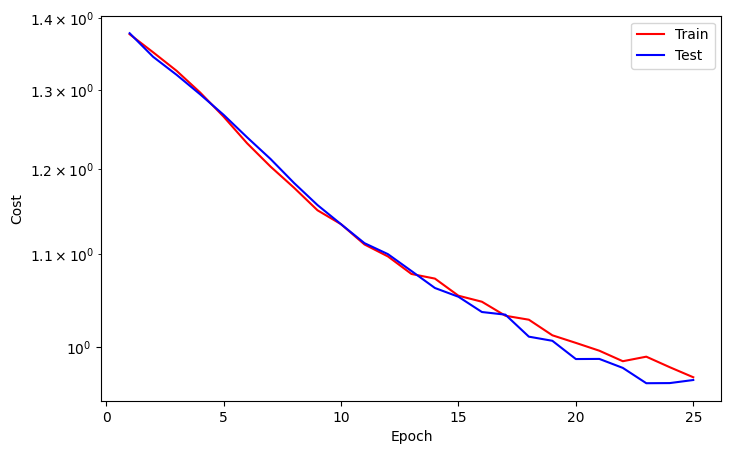

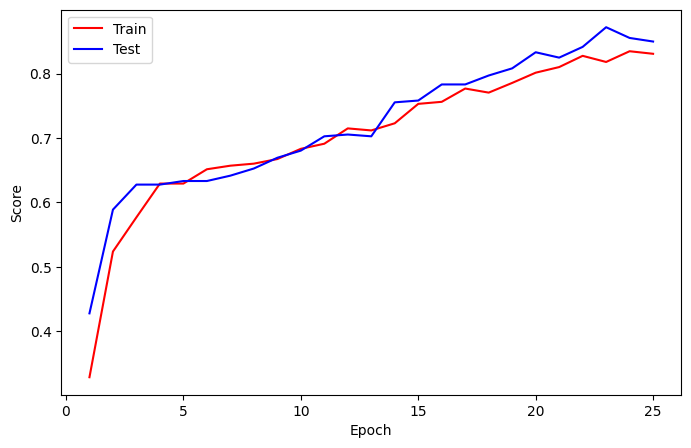

In [41]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device,scheduler, callback, epoch)

In [42]:
!pip install torchsummary

In [43]:
test_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/padi-data/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False)

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [49]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/weights_best.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    
    class_counts_labels = np.bincount(all_labels)
    class_counts_predictions = np.bincount(all_predictions)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 0.9820, Test Accuracy: 0.8778
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.58      0.71        45
           1       0.86      0.96      0.91        45
           2       0.80      0.98      0.88        45
           3       0.96      1.00      0.98        45

    accuracy                           0.88       180
   macro avg       0.89      0.88      0.87       180
weighted avg       0.89      0.88      0.87       180

Confusion Matrix:


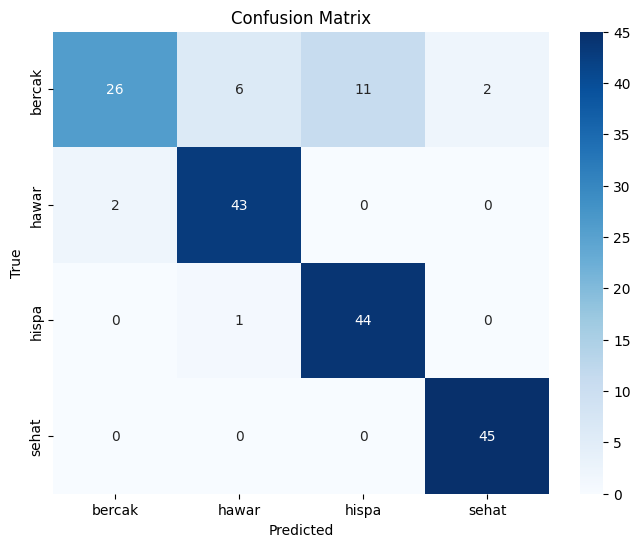

In [50]:
evaluate_model(model, testloader, criterion, device)

In [51]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [52]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))

model.feature[0][2].register_forward_hook(get_activation('relu'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))


img = Image.open('/kaggle/input/data-padi/test/bercak/IMG000000000013.jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

output = model(img_tensor)

/tmp/ipykernel_47/2727268787.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


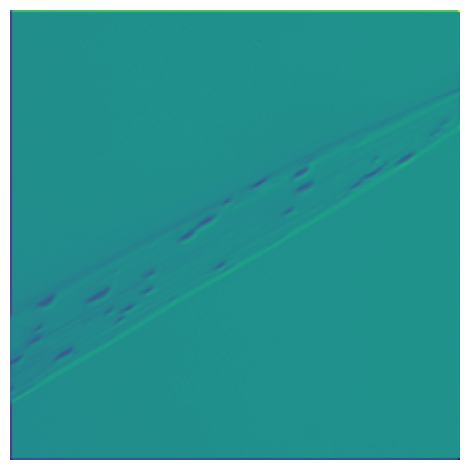

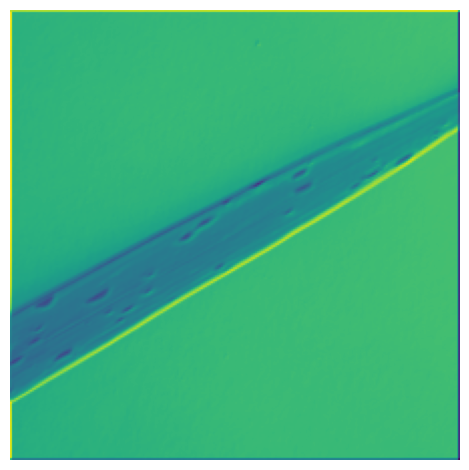

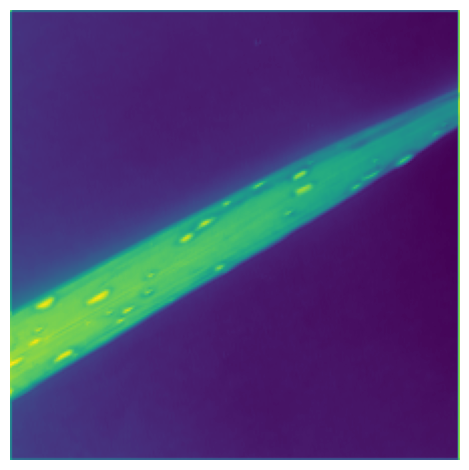

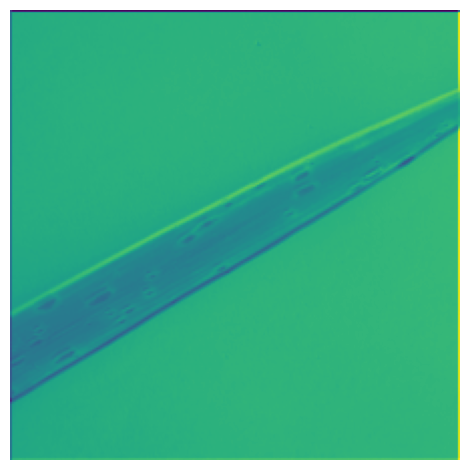

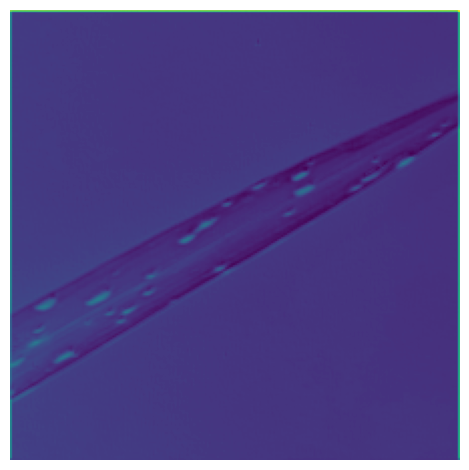

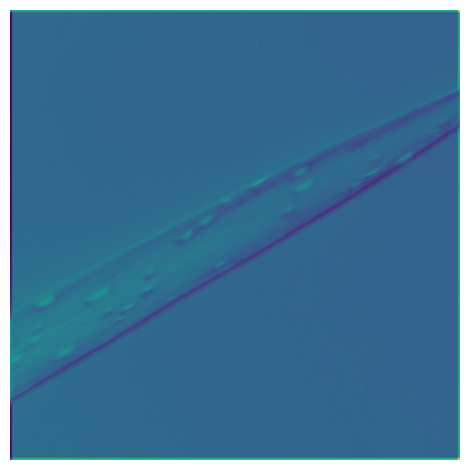

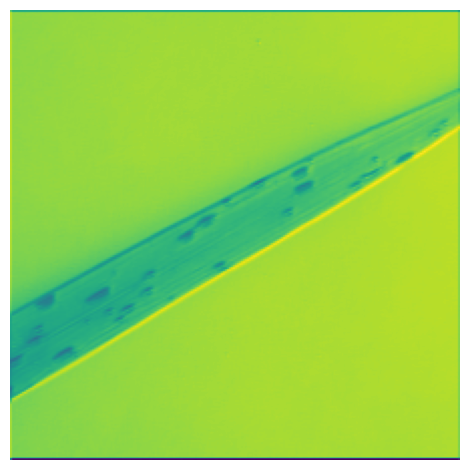

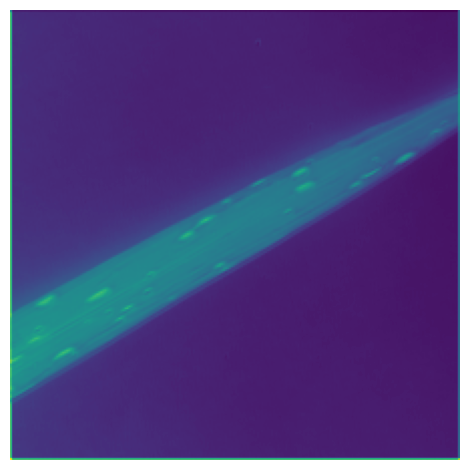

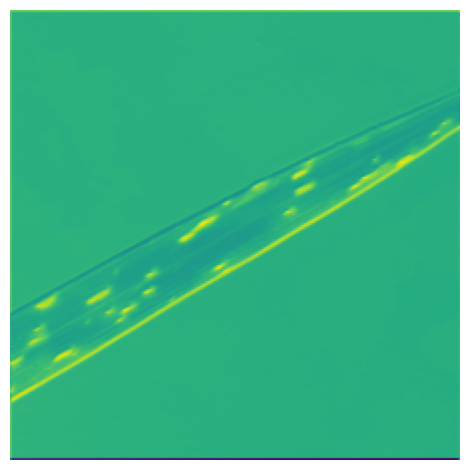

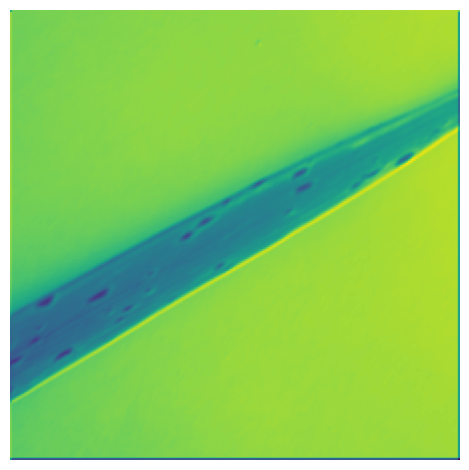

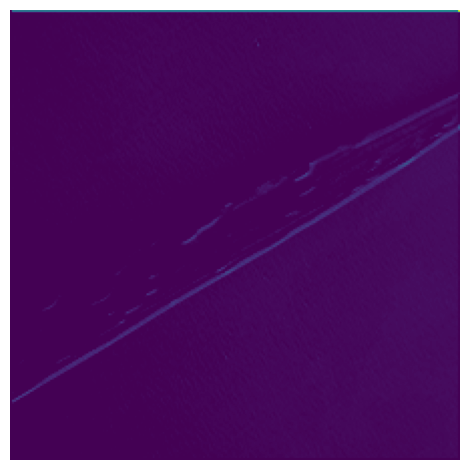

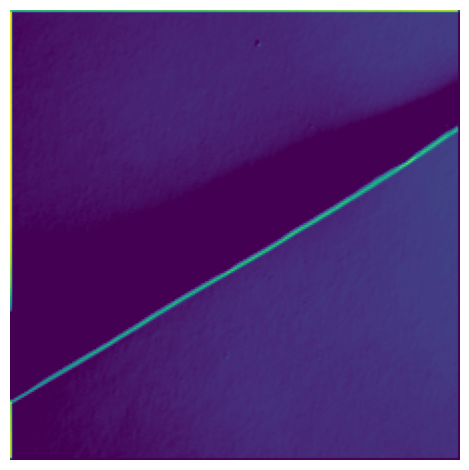

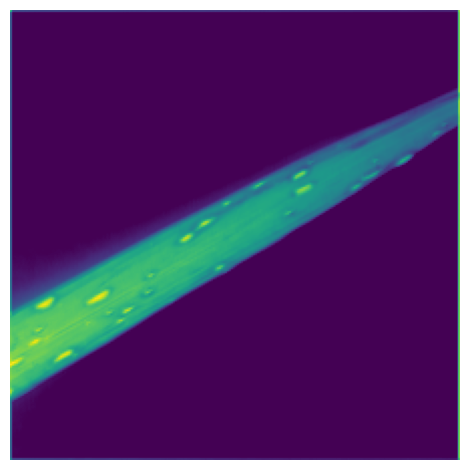

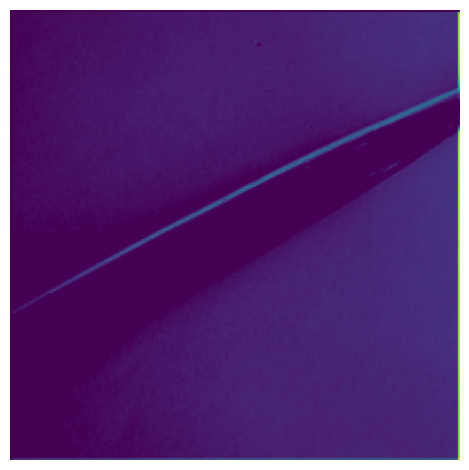

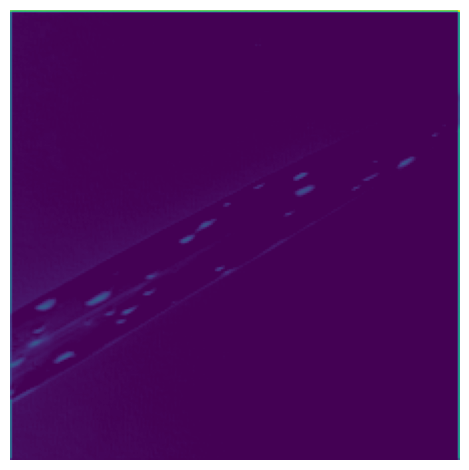

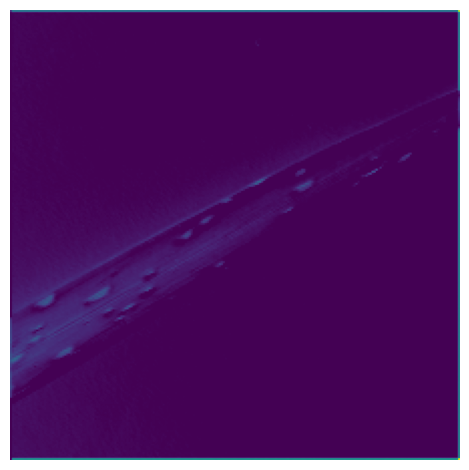

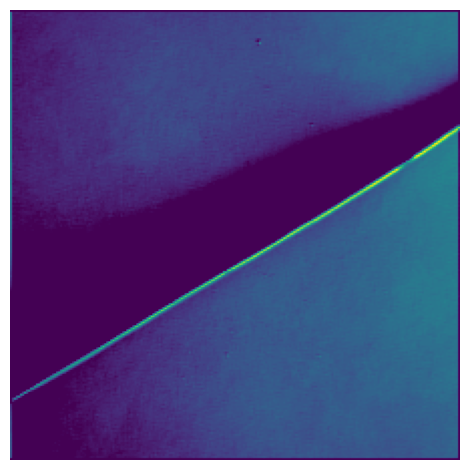

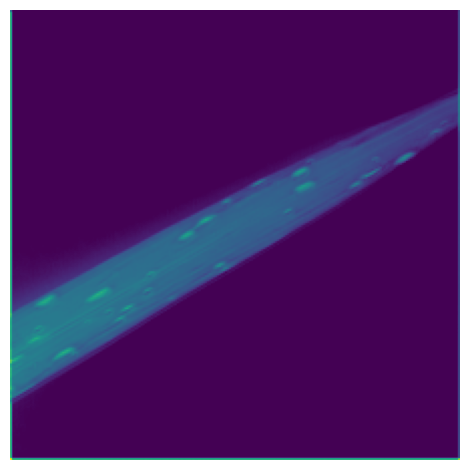

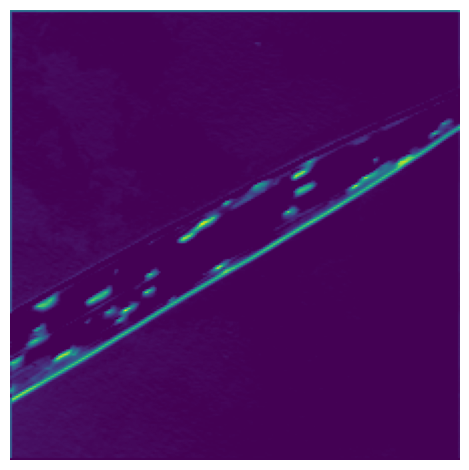

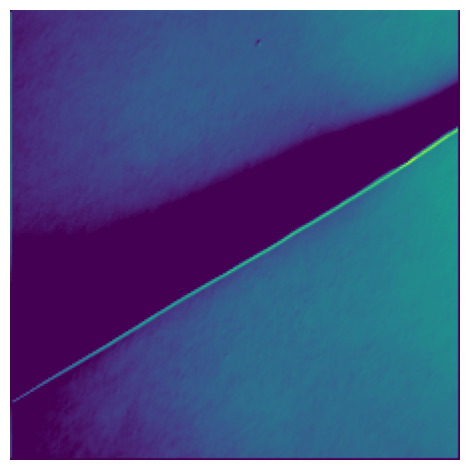

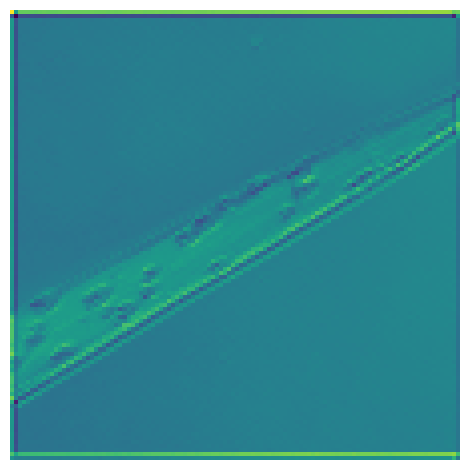

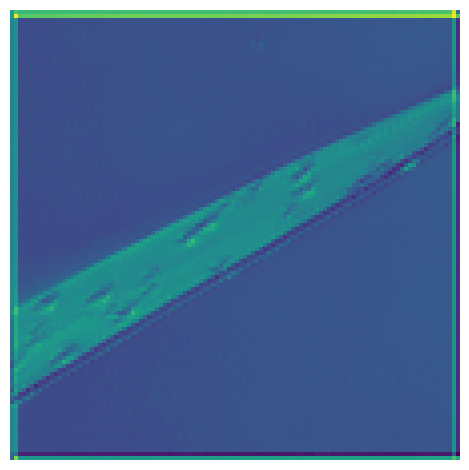

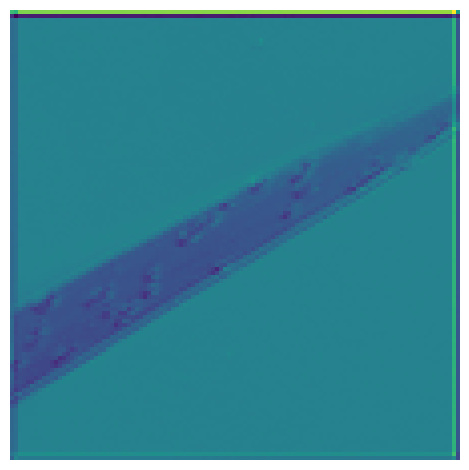

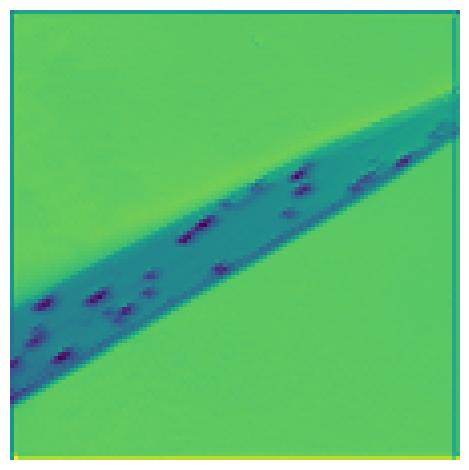

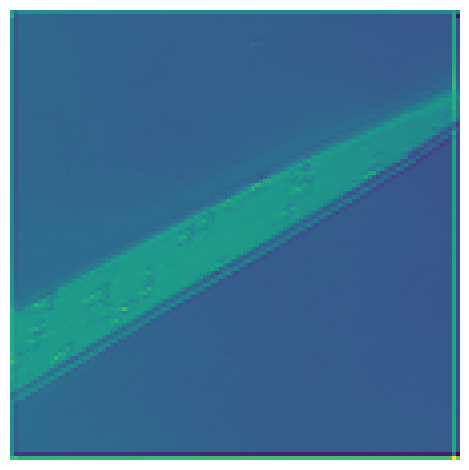

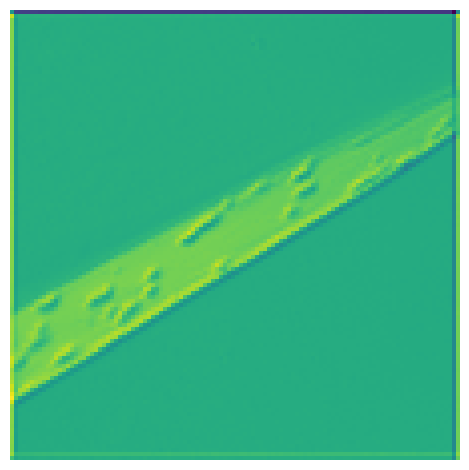

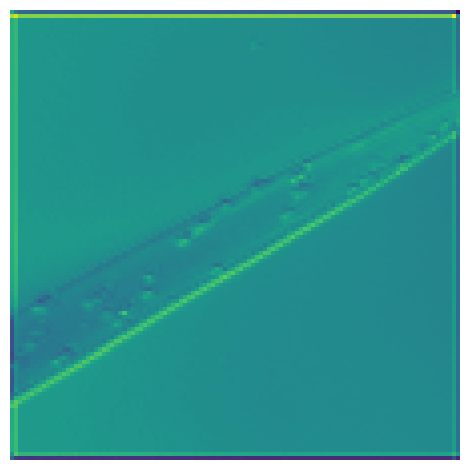

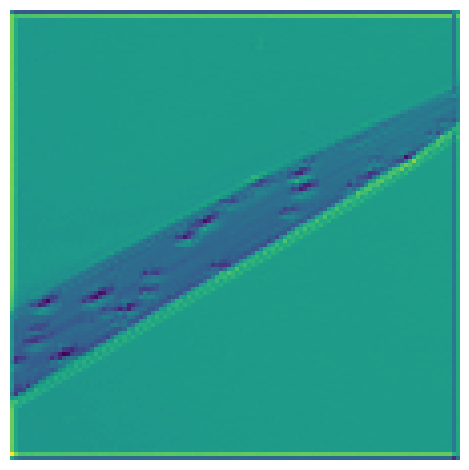

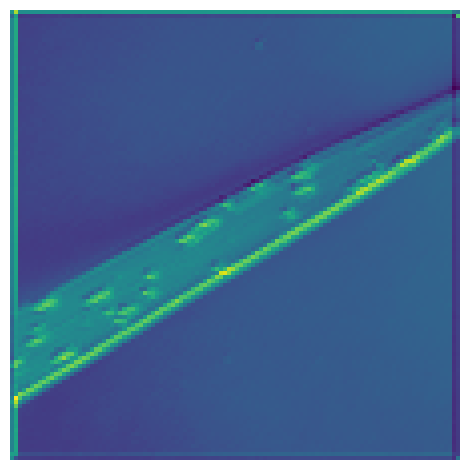

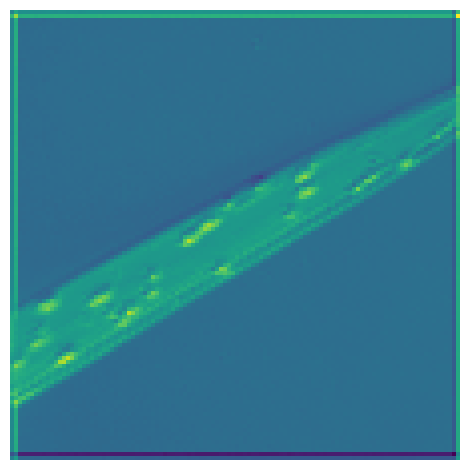

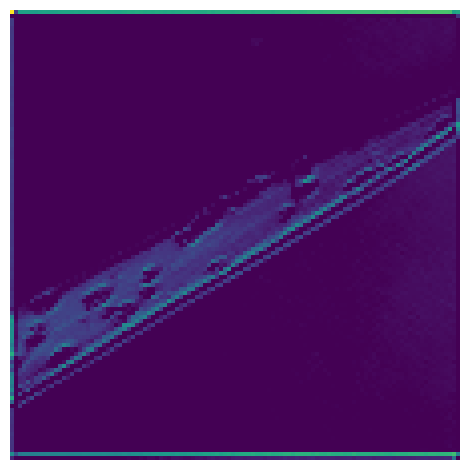

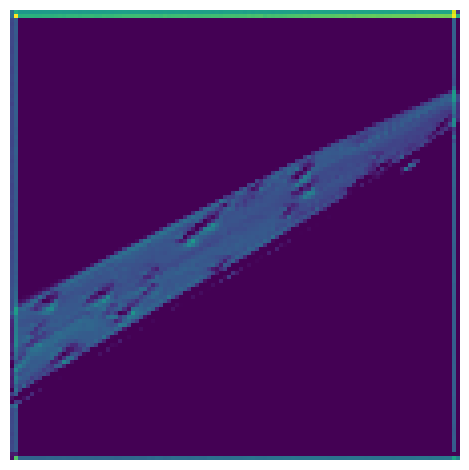

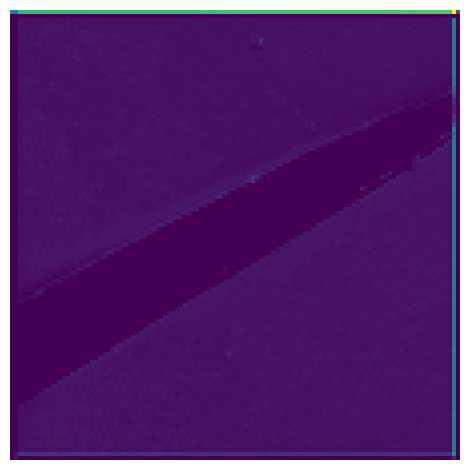

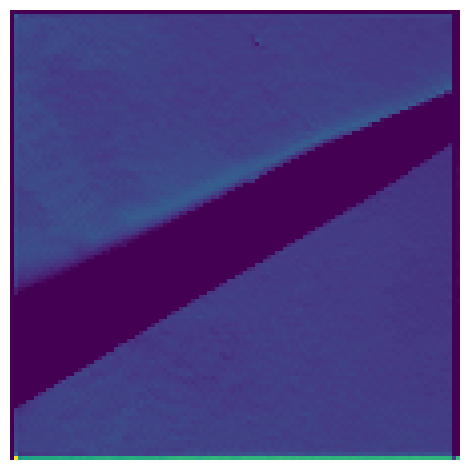

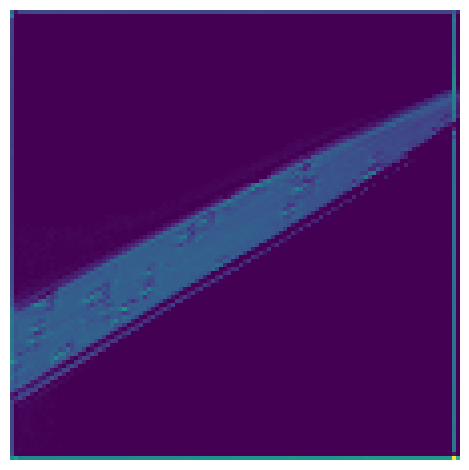

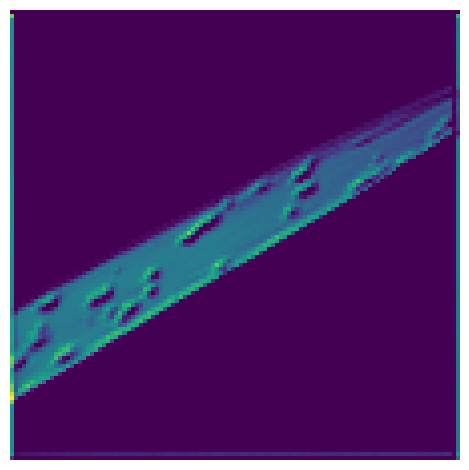

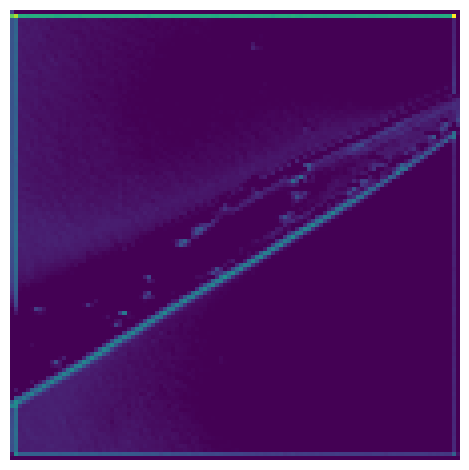

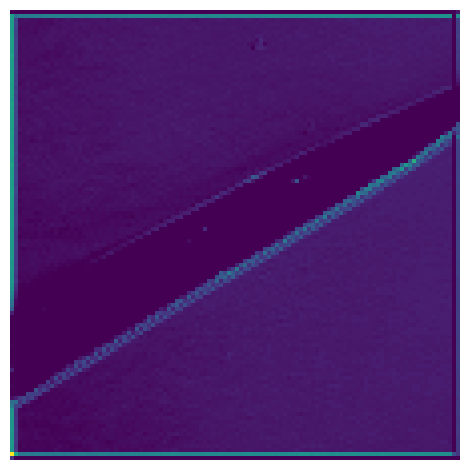

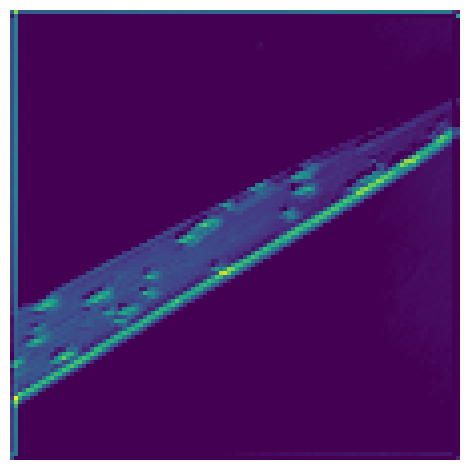

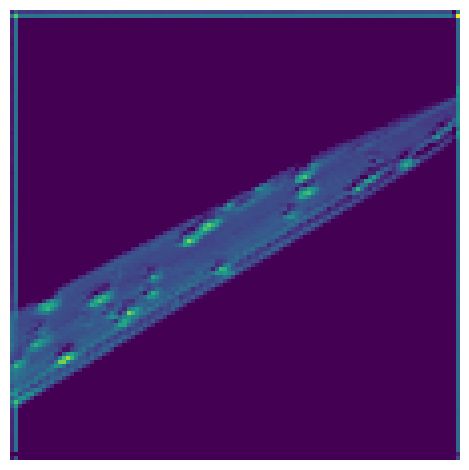

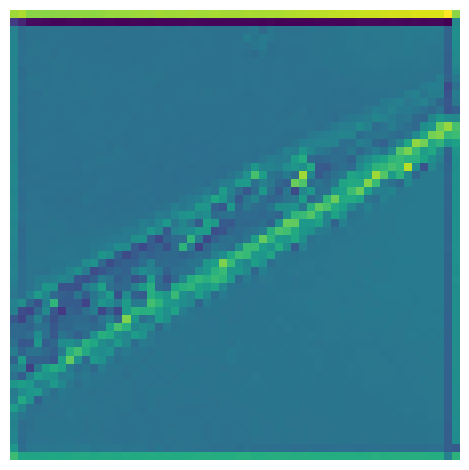

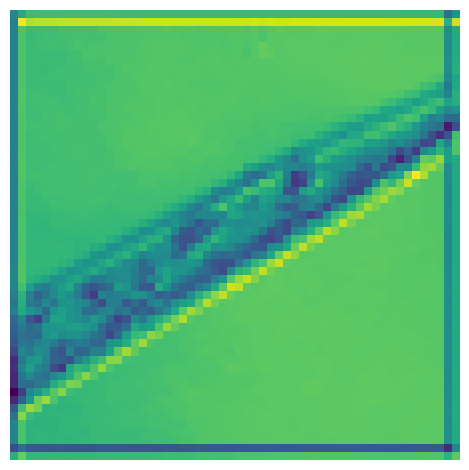

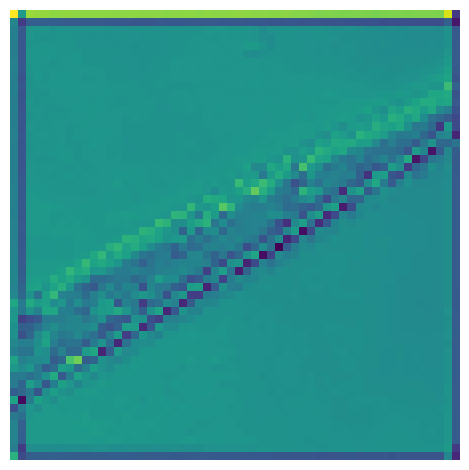

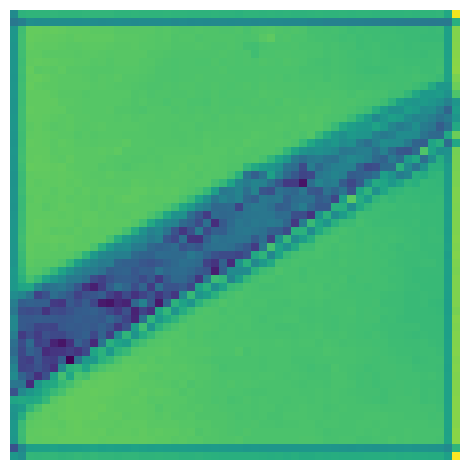

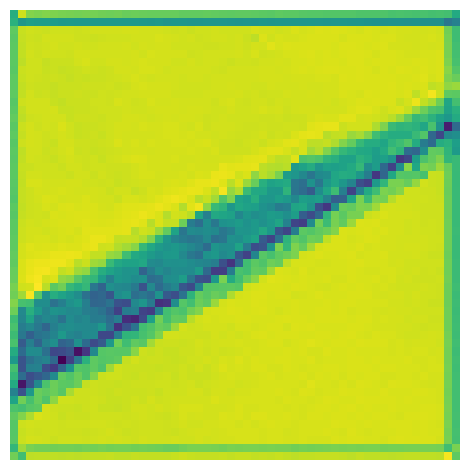

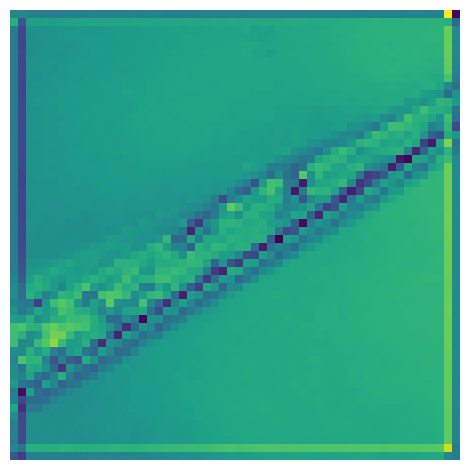

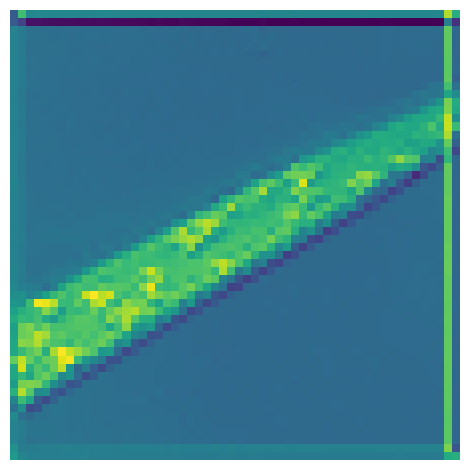

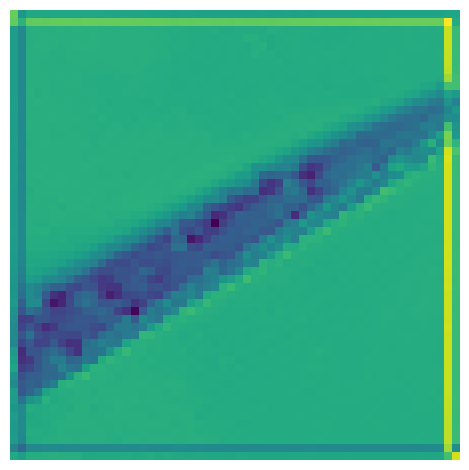

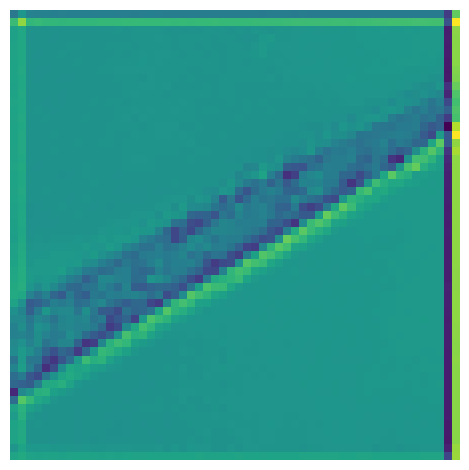

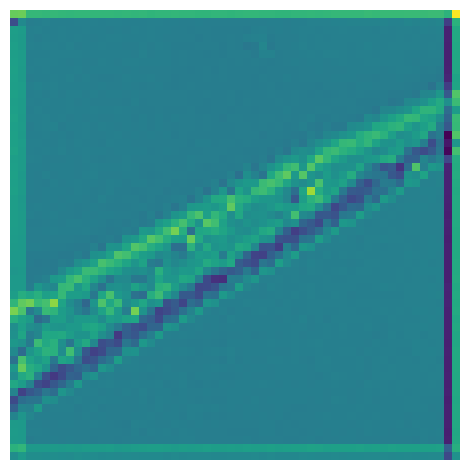

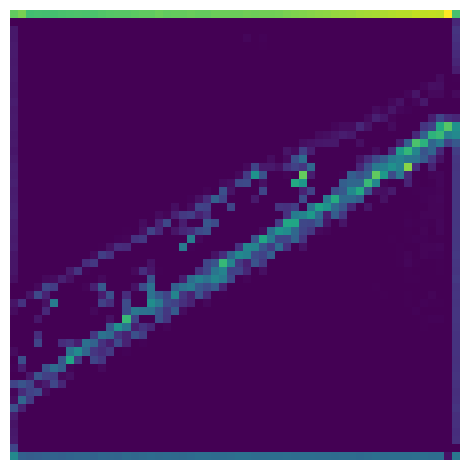

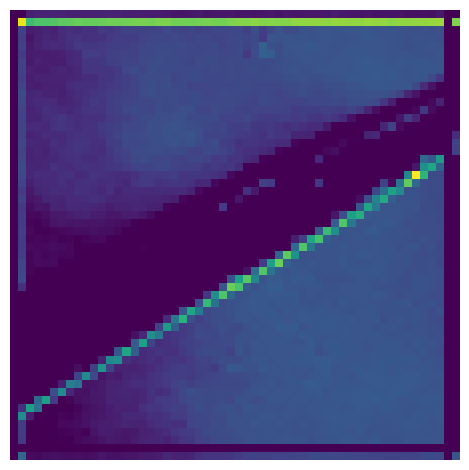

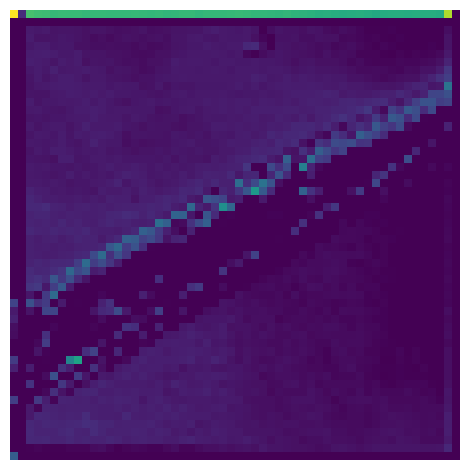

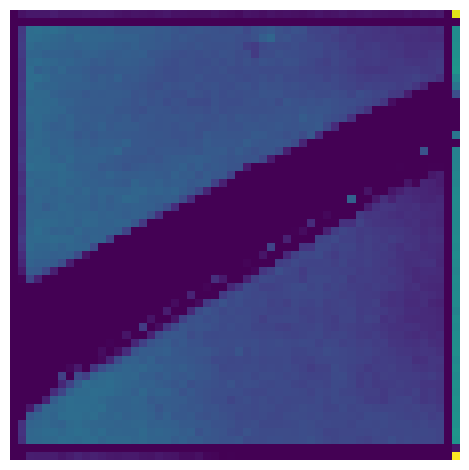

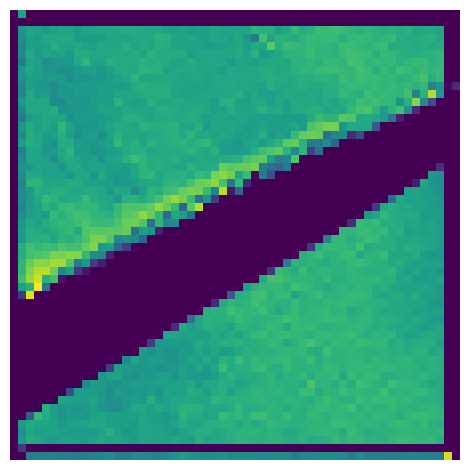

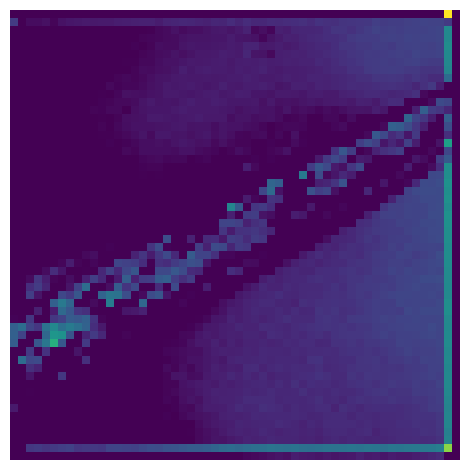

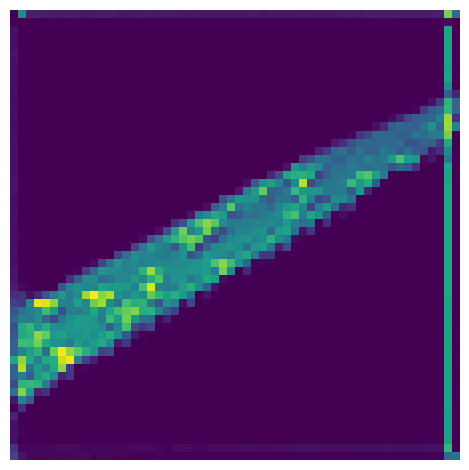

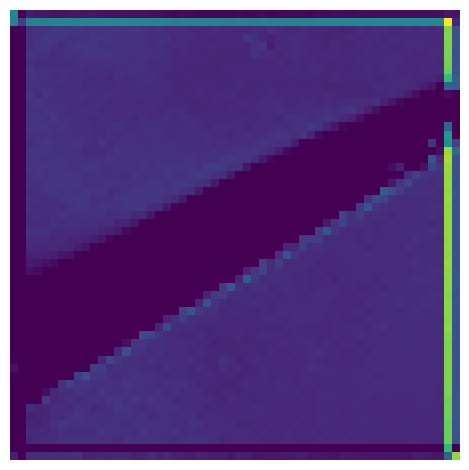

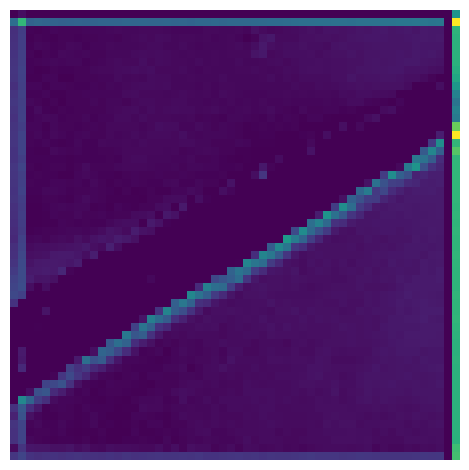

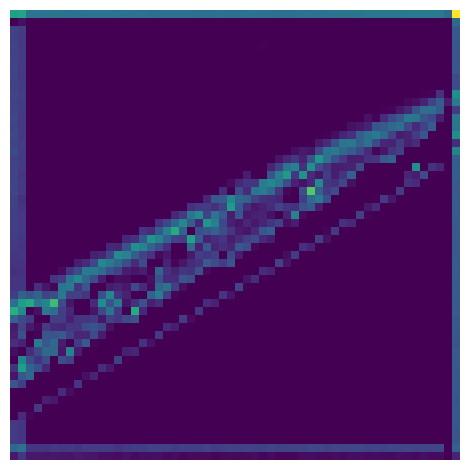

In [53]:
for name in activation1:
    folder_path = os.path.join('custom_12', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 1)
            ax.imshow(activation1[file][0, i].cpu().numpy())
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)


tensor([[[[1.0000, 0.9725, 0.7686, 0.9137, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7373, 0.8941, 1.0000, 1.0000],
          [1.0000, 0.9647, 0.7373, 0.8784, 1.0000, 1.0000],
          [1.0000, 0.9529, 0.7059, 0.8745, 1.0000, 1.0000],
          [1.0000, 0.9451, 0.6941, 0.8392, 0.9922, 1.0000],
          [1.0000, 0.9490, 0.6824, 0.7882, 0.9882, 1.0000]],

         [[1.0000, 0.9647, 0.7098, 0.8902, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7725, 0.8980, 1.0000, 1.0000],
          [1.0000, 0.9608, 0.7529, 0.8706, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.6902, 0.8627, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.7059, 0.8078, 0.9922, 1.0000],
          [1.0000, 0.9451, 0.6588, 0.7843, 0.9843, 1.0000]],

         [[1.0000, 0.9333, 0.4471, 0.7333, 1.0000, 1.0000],
          [1.0000, 0.9294, 0.4235, 0.6902, 1.0000, 1.0000],
          [1.0000, 0.9255, 0.4118, 0.6431, 0.9922, 1.0000],
          [1.0000, 0.9216, 0.3882, 0.6039, 0.9882, 1.0000],
          [1.0000, 0.9176, 0.3608, 0

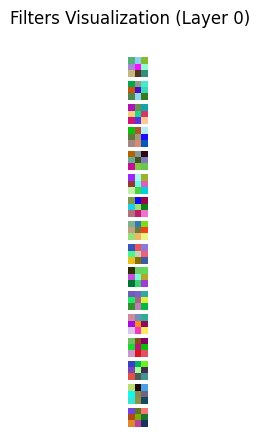

bias :tensor([ 0.0513, -0.1803,  0.0372,  0.0209,  0.0424, -0.0105, -0.0748, -0.0659,
        -0.1434, -0.1094,  0.1297,  0.0342, -0.0165, -0.0113,  0.1829,  0.0984])


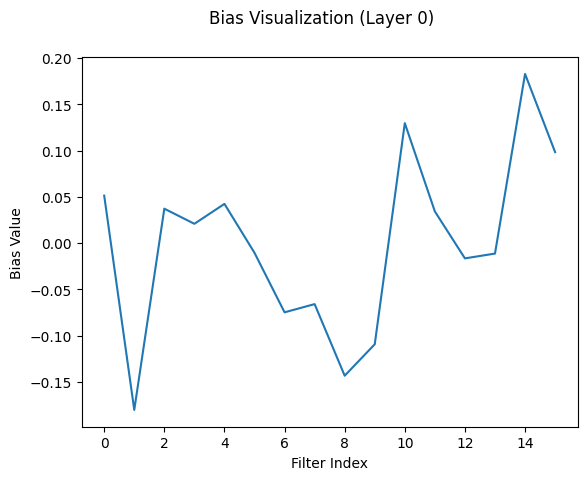

fitur :tensor([[[[ 1.7290e-01,  4.8330e-01,  5.4611e-01,  4.5878e-01,  5.2139e-01,
            3.3208e-01],
          [ 4.7568e-01,  8.0659e-01,  7.0660e-01,  6.8569e-01,  8.0885e-01,
            6.4557e-01],
          [ 4.7535e-01,  8.1454e-01,  7.1480e-01,  6.7339e-01,  8.0237e-01,
            6.4449e-01],
          [ 4.7214e-01,  7.9924e-01,  7.1041e-01,  6.6750e-01,  7.8787e-01,
            6.4257e-01],
          [ 4.6988e-01,  7.9021e-01,  6.8459e-01,  6.5309e-01,  7.6852e-01,
            6.3942e-01],
          [ 8.7651e-01,  9.4895e-01,  7.2786e-01,  7.7194e-01,  9.9654e-01,
            7.6258e-01]],

         [[-1.3592e-01, -3.6917e-01, -4.8549e-01, -3.2988e-01, -3.3214e-01,
           -2.5747e-01],
          [ 1.4100e-01, -3.7130e-01, -4.6943e-01, -2.0661e-01, -2.0949e-01,
           -3.6818e-01],
          [ 1.4247e-01, -3.5983e-01, -4.7799e-01, -1.9658e-01, -1.9161e-01,
           -3.6631e-01],
          [ 1.4131e-01, -3.6452e-01, -4.6747e-01, -2.1468e-01, -1.7591e-01,
      

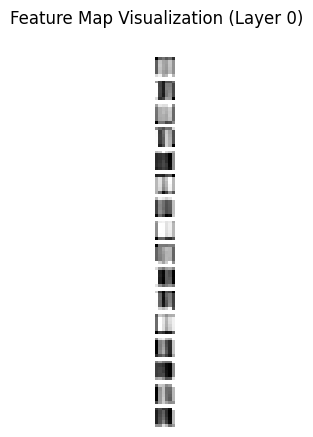

relu :tensor([[[[1.7290e-01, 4.8330e-01, 5.4611e-01, 4.5878e-01, 5.2139e-01,
           3.3208e-01],
          [4.7568e-01, 8.0659e-01, 7.0660e-01, 6.8569e-01, 8.0885e-01,
           6.4557e-01],
          [4.7535e-01, 8.1454e-01, 7.1480e-01, 6.7339e-01, 8.0237e-01,
           6.4449e-01],
          [4.7214e-01, 7.9924e-01, 7.1041e-01, 6.6750e-01, 7.8787e-01,
           6.4257e-01],
          [4.6988e-01, 7.9021e-01, 6.8459e-01, 6.5309e-01, 7.6852e-01,
           6.3942e-01],
          [8.7651e-01, 9.4895e-01, 7.2786e-01, 7.7194e-01, 9.9654e-01,
           7.6258e-01]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [1.4100e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [1.4247e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [1.4131e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [1.3939e-01, 0.0000e+00, 0.0000e

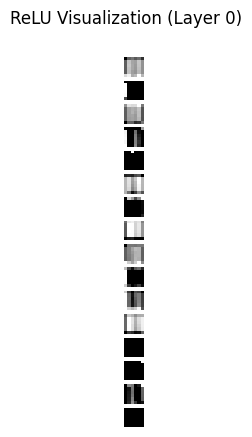

In [54]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)